# USER INTERFACE

In [1]:
%pylab inline
import xarray as xr
import roms_vort as romsv     # py script for ROMS_VORT
import importlib

Populating the interactive namespace from numpy and matplotlib


/data/mathlib/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/data/mathlib/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/data/mathlib/anaconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/mathlib/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.dat

## 1. results of the circulation pattern

In [2]:
data_dir = '../../canyon/'  # direction of DIAG and AVG output
avgfile = data_dir+'roms_avg.nc'
ds_avg = xr.open_dataset(avgfile)

In [15]:
#set the time step for output 
it0 = 2
# set the section showing the results
ksel = 6  # a zonal section along y=12km
xpsi = ds_avg.x_psi.isel(eta_psi=slice(0,1)).data/1000

Text(0, 0.5, 'y (km)')

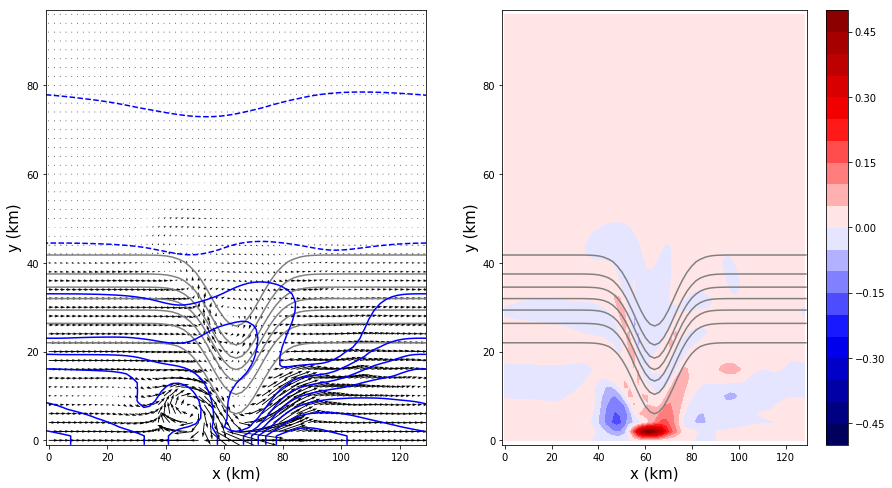

In [28]:
ubar0 = ds_avg.ubar.data[it0]
vbar0 = ds_avg.vbar.data[it0]
pm0 = ds_avg.pm.data
pn0 = ds_avg.pn.data
f0 = ds_avg.f.data
pm_p = 0.25*(pm0[:-1,:-1]+pm0[1:,:-1]+pm0[:-1,1:]+pm0[1:,1:])
pn_p = 0.25*(pn0[:-1,:-1]+pn0[1:,:-1]+pn0[:-1,1:]+pn0[1:,1:])
f_p = 0.25*(f0[:-1,:-1]+f0[1:,:-1]+f0[:-1,1:]+f0[1:,1:])
dubardy = (ubar0[1:,:]-ubar0[:-1,:])*pn_p
dvbardx = (vbar0[:,1:]-vbar0[:,:-1])*pm_p
vort2d = (dvbardx - dubardy)/f_p

fig = plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
plt.contour(ds_avg.x_rho.data/1000,ds_avg.y_rho.data/1000,ds_avg.h.data,colors='gray')
plt.contour(ds_avg.x_rho.data/1000,ds_avg.y_rho.data/1000,ds_avg.zeta.data[it0,:,:],colors='b')
# clabel(cc1,hh1,'manual','fontsize',fontsi0*0.7)
plt.quiver(ds_avg.x_psi.data/1000,ds_avg.y_psi.data/1000,\
    ds_avg.ubar.data[it0,:-1,:],ds_avg.vbar.data[it0,:,:-1])
plt.xlabel('x (km)',fontsize=15)
plt.ylabel('y (km)',fontsize=15)
subplot(1,2,2)
plt.contourf(ds_avg.x_psi.data/1000,ds_avg.y_psi.data/1000,vort2d,\
             levels=np.linspace(-0.5,0.5,21),vmin=-0.5,vmax=0.5,cmap=plt.cm.seismic)
plt.colorbar()
plt.contour(ds_avg.x_rho.data/1000,ds_avg.y_rho.data/1000,ds_avg.h.data,colors='gray')
plt.xlabel('x (km)',fontsize=15)
plt.ylabel('y (km)',fontsize=15)

In [10]:
# for the 2D depth-averaged vorticity equation
acce_2d    = romsv.vort_2d_ROMS_VORT("accel",it0)
adv_rPV_2d = romsv.vort_2d_ROMS_VORT("hadv",it0)
adv_bPV_2d = romsv.vort_2d_ROMS_VORT("cor",it0)
JEBAR      = romsv.vort_2d_ROMS_VORT("prsgrd",it0)
curl_Tb_2d = romsv.vort_2d_ROMS_VORT("bstr",it0)
curl_Ts_2d = romsv.vort_2d_ROMS_VORT("sstr",it0)
hvis_2d    = romsv.vort_2d_ROMS_VORT("hvisc",it0)

Res_2d = -acce_2d+adv_rPV_2d+adv_bPV_2d+JEBAR+curl_Tb_2d+curl_Ts_2d+hvis_2d

Text(0, 0.5, '2D vorticity balance $(s^{-2})$')

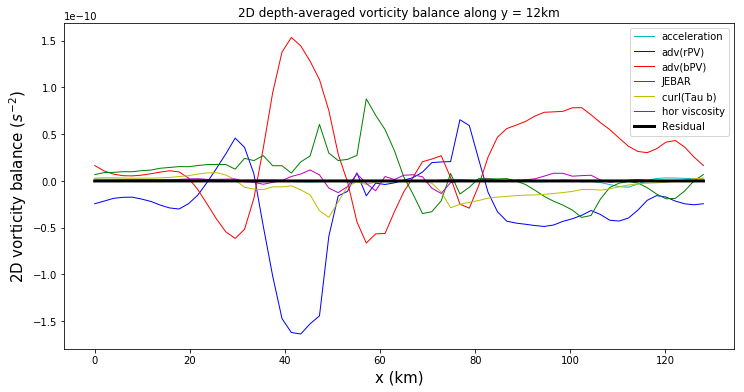

In [21]:
fig = plt.figure(figsize=(12, 6))
ln_acce, = plt.plot(xpsi[0],acce_2d[ksel,:], linewidth = '1',color='c')
ln_arpv, = plt.plot(xpsi[0],adv_rPV_2d[ksel,:], linewidth = '1',color='b')
ln_abpv, = plt.plot(xpsi[0],adv_bPV_2d[ksel,:], linewidth = '1',color='r')
ln_jeba, = plt.plot(xpsi[0],JEBAR[ksel,:], linewidth = '1',color='g')
ln_crtb, = plt.plot(xpsi[0],curl_Tb_2d[ksel,:], linewidth = '1',color='y')
# plt.plot(curl_Ts_2d[ksel,:])
ln_hvis, = plt.plot(xpsi[0],hvis_2d[ksel,:], linewidth = '1',color='m')
ln_res2, = plt.plot(xpsi[0],Res_2d[ksel,:], linewidth = '3',color='k')
plt.legend([ln_acce,ln_arpv,ln_abpv,ln_jeba,ln_crtb,ln_hvis,ln_res2],\
           ['acceleration','adv(rPV)','adv(bPV)','JEBAR','curl(Tau b)','hor viscosity','Residual'])
plt.title('2D depth-averaged vorticity balance along y = 12km')
plt.xlabel('x (km)',fontsize=15)
plt.ylabel(r'2D vorticity balance $(s^{-2})$',fontsize=15)

In [23]:
# for the 2D depth-integrated transport vorticity equation
acce_2dtrans    = romsv.vort_2dtrans_ROMS_VORT("accel",it0)
hadv_2dtrans    = romsv.vort_2dtrans_ROMS_VORT("hadv",it0)
BPT             = romsv.vort_2dtrans_ROMS_VORT("cor",it0)+ \
                  romsv.vort_2dtrans_ROMS_VORT("prsgrd",it0)
curl_Tb_2dtrans = romsv.vort_2dtrans_ROMS_VORT("bstr",it0)
curl_Ts_2dtrans = romsv.vort_2dtrans_ROMS_VORT("sstr",it0)
hvis_2dtrans    = romsv.vort_2dtrans_ROMS_VORT("hvisc",it0)

Res_2dtrans = -acce_2dtrans+hadv_2dtrans+BPT+curl_Tb_2dtrans+curl_Ts_2dtrans+hvis_2dtrans

Text(0, 0.5, 'vorticity balance $(m s^{-2})$')

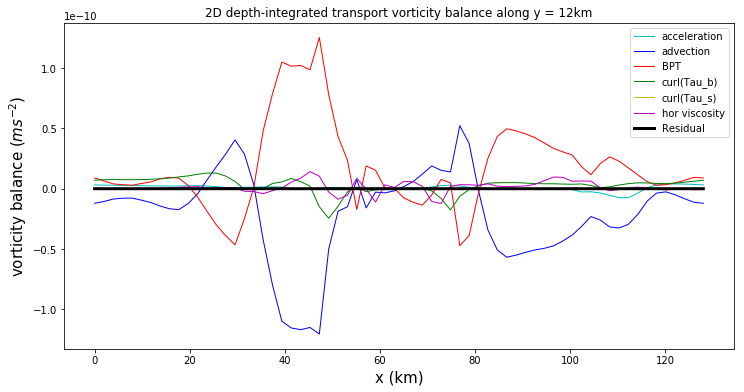

In [24]:
fig = plt.figure(figsize=(12, 6))
ln_acce, = plt.plot(xpsi[0],acce_2dtrans[ksel,:], linewidth = '1',color='c')
ln_hadv, = plt.plot(xpsi[0],hadv_2dtrans[ksel,:], linewidth = '1',color='b')
ln_bpt,  = plt.plot(xpsi[0],BPT[ksel,:], linewidth = '1',color='r')
ln_crtb, = plt.plot(xpsi[0],curl_Tb_2dtrans[ksel,:], linewidth = '1',color='g')
ln_crts, = plt.plot(xpsi[0],curl_Ts_2dtrans[ksel,:], linewidth = '1',color='y')
ln_hvis, = plt.plot(xpsi[0],hvis_2dtrans[ksel,:], linewidth = '1',color='m')
ln_res2,= plt.plot(xpsi[0],Res_2dtrans[ksel,:], linewidth = '3',color='k')
plt.legend([ln_acce,ln_hadv,ln_bpt,ln_crtb,ln_crts,ln_hvis,ln_res2],\
           ['acceleration','advection','BPT','curl(Tau_b)','curl(Tau_s)','hor viscosity','Residual'])
plt.title('2D depth-integrated transport vorticity balance along y = 12km')
plt.xlabel('x (km)',fontsize=15)
plt.ylabel(r'vorticity $(m s^{-2})$',fontsize=15)

In [25]:
# for the 3D depth-dependent vorticity equation
accel_3d = romsv.vort_3d_ROMS_VORT("accel",it0)
nonli_3d = romsv.vort_3d_ROMS_VORT("hadv",it0)+romsv.vort_3d_ROMS_VORT("vadv",it0)
diver_3d = romsv.vort_3d_ROMS_VORT("cor",it0)
vvisc_3d = romsv.vort_3d_ROMS_VORT("vvisc",it0)
hvisc_3d = romsv.vort_3d_ROMS_VORT("hvisc",it0)

Res_3d   = -accel_3d+nonli_3d+diver_3d+vvisc_3d+hvisc_3d

Text(0, 0.5, 'vorticity $(m s^{-2})$')

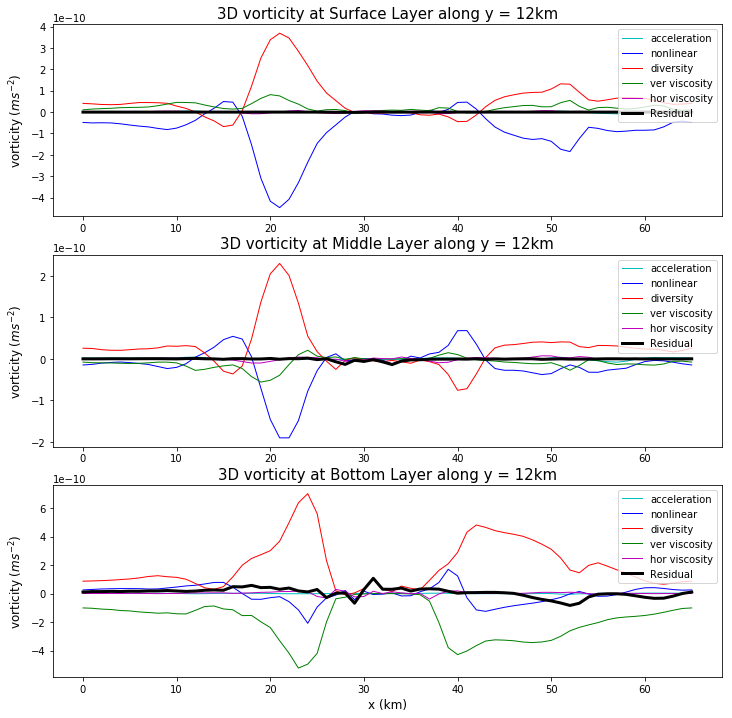

In [27]:
fig = plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
klev = 14
ln_acce, = plt.plot(accel_3d[klev,ksel,:], linewidth = '1',color='c')
ln_hadv, = plt.plot(nonli_3d[klev,ksel,:], linewidth = '1',color='b')
ln_dive, = plt.plot(diver_3d[klev,ksel,:], linewidth = '1',color='r')
ln_vvis, = plt.plot(vvisc_3d[klev,ksel,:], linewidth = '1',color='g')
ln_hvis, = plt.plot(hvisc_3d[klev,ksel,:], linewidth = '1',color='m')
ln_res3,= plt.plot(Res_3d[klev,ksel,:], linewidth = '3',color='k')
plt.legend([ln_acce,ln_hadv,ln_dive,ln_vvis,ln_hvis,ln_res3],\
           ['acceleration','nonlinear','diversity','ver viscosity','hor viscosity','Residual'],loc=1)
plt.title('3D vorticity at Surface Layer along y = 12km',fontsize=15)
# plt.xlabel('x (km)',fontsize=12)
plt.ylabel(r'vorticity $(m s^{-2})$',fontsize=12)

plt.subplot(3,1,2)
klev = 7
ln_acce, = plt.plot(accel_3d[klev,ksel,:], linewidth = '1',color='c')
ln_hadv, = plt.plot(nonli_3d[klev,ksel,:], linewidth = '1',color='b')
ln_dive, = plt.plot(diver_3d[klev,ksel,:], linewidth = '1',color='r')
ln_vvis, = plt.plot(vvisc_3d[klev,ksel,:], linewidth = '1',color='g')
ln_hvis, = plt.plot(hvisc_3d[klev,ksel,:], linewidth = '1',color='m')
ln_res3,= plt.plot(Res_3d[klev,ksel,:], linewidth = '3',color='k')
plt.legend([ln_acce,ln_hadv,ln_dive,ln_vvis,ln_hvis,ln_res3],\
           ['acceleration','nonlinear','diversity','ver viscosity','hor viscosity','Residual'],loc=1)
plt.title('3D vorticity at Middle Layer along y = 12km',fontsize=15)
# plt.xlabel('x (km)',fontsize=12)
plt.ylabel(r'vorticity $(m s^{-2})$',fontsize=12)

plt.subplot(3,1,3)
klev = 1
ln_acce, = plt.plot(accel_3d[klev,ksel,:], linewidth = '1',color='c')
ln_hadv, = plt.plot(nonli_3d[klev,ksel,:], linewidth = '1',color='b')
ln_dive, = plt.plot(diver_3d[klev,ksel,:], linewidth = '1',color='r')
ln_vvis, = plt.plot(vvisc_3d[klev,ksel,:], linewidth = '1',color='g')
ln_hvis, = plt.plot(hvisc_3d[klev,ksel,:], linewidth = '1',color='m')
ln_res3,= plt.plot(Res_3d[klev,ksel,:], linewidth = '3',color='k')
plt.legend([ln_acce,ln_hadv,ln_dive,ln_vvis,ln_hvis,ln_res3],\
           ['acceleration','nonlinear','diversity','ver viscosity','hor viscosity','Residual'],loc=1)
plt.title('3D vorticity at Bottom Layer along y = 12km',fontsize=15)
plt.xlabel('x (km)',fontsize=12)
plt.ylabel(r'vorticity $(m s^{-2})$',fontsize=12)
